In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D,ZeroPadding2D
from tensorflow.keras.models import Model, load_model
from keras.models import Sequential



In [2]:
train_path = '../input/overnight-hackathon/Train_Images/Train_Images/'
test_path = '../input/overnight-hackathon/Test_Image/Test_Image/'

In [3]:

path = Path(train_path)
filenames = list(map(lambda x: x.name, path.glob('*')))
print(len(filenames))


29497


In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

image_path, age_labels, gender_labels = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    gender_labels.append(temp[3])
    age_labels.append(int(temp[4].split('.')[0]))
    



****From Unstructured data to structured data

In [5]:

df = pd.DataFrame()
df['Image'], df['Age'] , df['Gender']= image_path, age_labels, gender_labels

In [6]:
df.head()

,Image,Age,Gender
0,IMG_14598_HI_F_24.jpg,24,F
1,IMG_17124_HI_M_27.jpg,27,M
2,IMG_27635_HI_F_24.jpg,24,F
3,IMG_11893_HI_M_35.jpg,35,M
4,IMG_21633_HI_F_32.jpg,32,F


In [7]:
print(df.dtypes)

Image     object
Age        int64
Gender    object
dtype: object


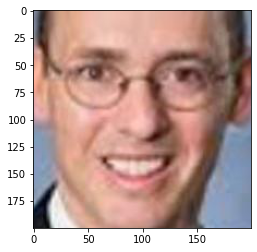

In [8]:
img = Image.open(train_path + df.Image[3])
plt.imshow(img)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

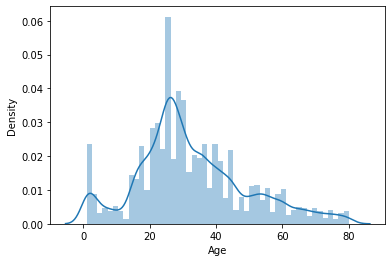

In [9]:
sns.distplot(df.Age)


Plotting Images

In [10]:
gender_dict = {"M":0,"F":1}

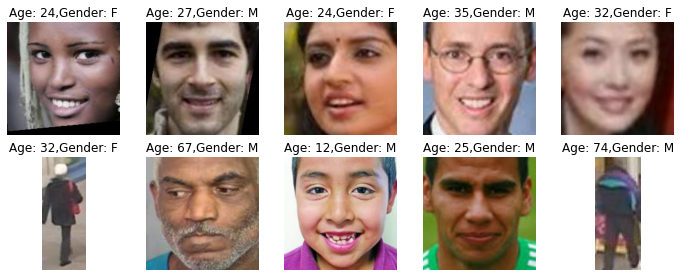

In [11]:
files = df.iloc[0:10]
plt.figure(figsize=(12,12))
for index, file, Age,Gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(train_path+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {Age},Gender: {Gender}")
    plt.axis('off')

In [12]:
train, test = train_test_split(df, test_size = 0.20, random_state=1)

In [13]:
train.head()

,Image,Age,Gender
14257,IMG_18148_HI_F_25.jpg,25,F
17850,IMG_11086_HI_F_27.jpg,27,F
2966,IMG_3756_FI_F_36.jpg,36,F
18062,IMG_5577_FI_M_73.jpg,73,M
12741,IMG_17261_HI_F_41.jpg,41,F


Extracting features

In [14]:
x_train, x_test = [], []
for file in train.Image:
    img = load_img(train_path +file, color_mode = "grayscale")
    img = img.resize((128,128),Image.ANTIALIAS)#Image.ANTIALIAS
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

for file in test.Image:
    img = load_img(train_path +file, color_mode = "grayscale")
    img = img.resize((128,128),Image.ANTIALIAS)
    img = np.array(img)
    x_test.append(img)

x_test = np.array(x_test)

x_test = x_test.reshape(len(x_test),128,128,1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  


In [15]:
x_train.shape

(23597, 128, 128, 1)

Normalizing data

In [16]:
#x_train = x_train/255
#x_test = x_test/255

In [17]:
y_age = np.array(train.Age)
y_test = np.array(test.Age)

In [18]:
y_age

array([25, 27, 36, ..., 40, 16, 37])

In [19]:
input_size = (128,128,1)

Creating model

model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,1),
                   pooling='avg',classes=None,
                   weights=None)
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)

In [20]:

#model.compile(optimizer = 'adam', loss =['mse'],metrics=['accuracy'])
#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dense(256, activation ='relu'))
#model.add(Dense(128, activation ='relu'))
#model.add(Dense(1, activation='relu'))

In [21]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)

dropout_2 = Dropout(0.4)(dense_3)

output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_2])

2022-11-16 17:02:58.754778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:02:58.851918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:02:58.852916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:02:58.854954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 256)       295168

In [23]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3,verbose=1,min_delta=0.0001)

callbacks_list=[early_stopping,reduce_learningrate]

In [24]:
model.compile(optimizer = 'Adam',loss = 'mse',metrics=['accuracy'])
history = model.fit(x=x_train,y=y_age,validation_split=0.2,epochs = 28, batch_size=128,shuffle = True)

2022-11-16 17:03:02.162299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/28


2022-11-16 17:03:03.585506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


148/148 [==============================] - 17s 60ms/step - loss: 493.8633 - accuracy: 0.0258 - val_loss: 297.6243 - val_accuracy: 0.0284
Epoch 2/28
148/148 [==============================] - 8s 54ms/step - loss: 217.7816 - accuracy: 0.0251 - val_loss: 176.9453 - val_accuracy: 0.0189
Epoch 3/28
148/148 [==============================] - 8s 54ms/step - loss: 184.8416 - accuracy: 0.0181 - val_loss: 251.8399 - val_accuracy: 0.0269
Epoch 4/28
148/148 [==============================] - 8s 55ms/step - loss: 160.7692 - accuracy: 0.0106 - val_loss: 325.2862 - val_accuracy: 0.0034
Epoch 5/28
148/148 [==============================] - 8s 54ms/step - loss: 150.8808 - accuracy: 0.0065 - val_loss: 170.5125 - val_accuracy: 0.0123
Epoch 6/28
148/148 [==============================] - 8s 54ms/step - loss: 138.6607 - accuracy: 0.0052 - val_loss: 310.2943 - val_accuracy: 0.0163
Epoch 7/28
148/148 [==============================] - 8s 54ms/step - loss: 127.3860 - accuracy: 0.0046 - val_loss: 131.2334 - va

Visualizing loss

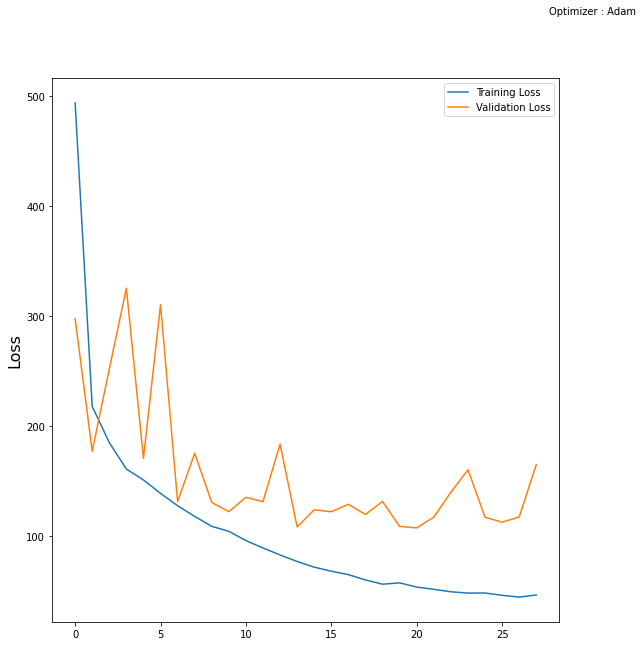

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.suptitle('Optimizer : Adam', fontsize = 10)
plt.ylabel('Loss',fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')


In [26]:
x_test = x_test/255

Predicting test image


In [27]:

index=8

print("Original: Age = " ,y_test[index])

pred = model.predict(x_test[index].reshape(1,128, 128, 1))

print(pred.mean())


Original: Age =  20
33.840096


In [28]:
df1 = pd.read_csv('../input/overnight-hackathon/Test_Data.csv')
df1.head()

,img_file
0,IMG_10000_HI_M.jpg
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg


In [29]:
test_path = '../input/overnight-hackathon/Test_Image/Test_Image/'
data = Path(test_path)
#df1 = pd.read_csv('../input/overnight-hackathon/Test_Data.csv')
names = df1['img_file']

#names = list(map(lambda x: x.name, data.glob('*')))
print(len(names))
print(names[0])

12642
IMG_10000_HI_M.jpg


In [30]:
paths = []

for name in names:
    paths.append(name)
    temp = name.split('_')
    

In [31]:
sub_df = pd.DataFrame()
sub_df['Images'] = paths
sub_df.head()

,Images
0,IMG_10000_HI_M.jpg
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg


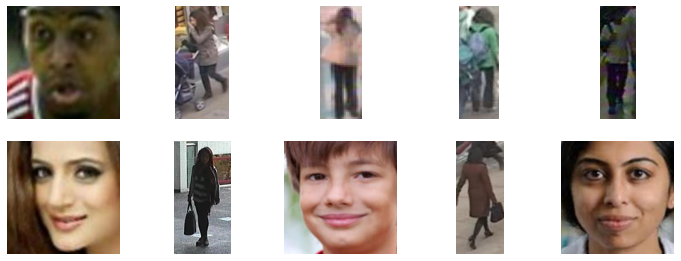

In [32]:
Files = sub_df.iloc[0:10]
plt.figure(figsize=(12,12))
for index, File in Files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(test_path+File)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')

In [33]:
X_pred = []
for file in paths:
    img = load_img(test_path +file, color_mode="grayscale")
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    X_pred.append(img)

X_pred = np.array(X_pred)

X_pred = X_pred.reshape(len(X_pred), 128,128,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


In [34]:
X_pred.shape

(12642, 128, 128, 1)

17.674948


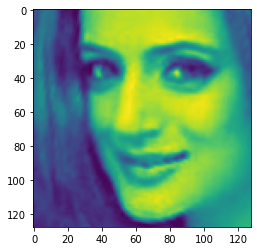

In [35]:
#X_pred = X_pred/255
index =5

plt.imshow(X_pred[index].reshape(128,128,1))
prediction = model.predict(X_pred[index].reshape(1, 128, 128, 1))
print(prediction.mean())

In [36]:
Y_pred = []
for index in range(len(X_pred)):
    pred=model.predict(X_pred[index].reshape(1,128,128,1))
    pred=pred.mean()
    Y_pred.append(pred)
    

In [37]:
DF = pd.read_csv('../input/overnight-hackathon/Test_Data.csv')
DF.head()

,img_file
0,IMG_10000_HI_M.jpg
1,IMG_10001_FI_F.jpg
2,IMG_10002_FI_F.jpg
3,IMG_10003_FI_F.jpg
4,IMG_10004_FI_M.jpeg


In [38]:
DF['Age'] = Y_pred
DF.head()

,img_file,Age
0,IMG_10000_HI_M.jpg,31.342249
1,IMG_10001_FI_F.jpg,24.891104
2,IMG_10002_FI_F.jpg,29.965666
3,IMG_10003_FI_F.jpg,22.991940
4,IMG_10004_FI_M.jpeg,28.527065


In [39]:
DF.to_csv('final3.csv')